In [1]:
%matplotlib inline

import numpy as np
import scipy.special as spc
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.5)

# t = np.linspace(0, 7.0, 201)
# ss, cc = fresnel(t / np.sqrt(np.pi / 2))
# # scaled_ss = np.sqrt(np.pi / 2) * ss
# # scaled_cc = np.sqrt(np.pi / 2) * cc
# # plt.plot(t, scaled_cc, 'g--', t, scaled_ss, 'r-', linewidth=2)

# tot = 0.5 * (0.5 + ss + 0.5 + cc)**2

# plt.plot(t, tot, 'g--', t, ss, 'r-', linewidth=2)
# plt.grid(True)
# plt.show()

### Definisikan sebuah fungsi pembuat data

Data yang akan dihasilkan berupa data okultasi yang didekati melalui persamaan Fresnel.

In [2]:
def make_data(w, dy=0.5, N=1000, rseed=100):
    rand = np.random.RandomState(rseed)
#     t = 100*rand.rand(N) # x is not equally spaced
#     t = np.linspace(-10, 10, 1000)
    cc, ss = spc.fresnel(w / np.sqrt(np.pi/2))
    
    y = 0.5 * (0.5 + cc + 0.5 + ss)**2 # Fresnel function to simulate real data
    y += dy * rand.randn(N) # add some noise
    
    return w, y


w = np.linspace(-10,30,1000)
x, y = make_data(w) # remember, the x values are dimensionless, and a function of w

### Plot generated data

Text(0,0.5,'$I$')

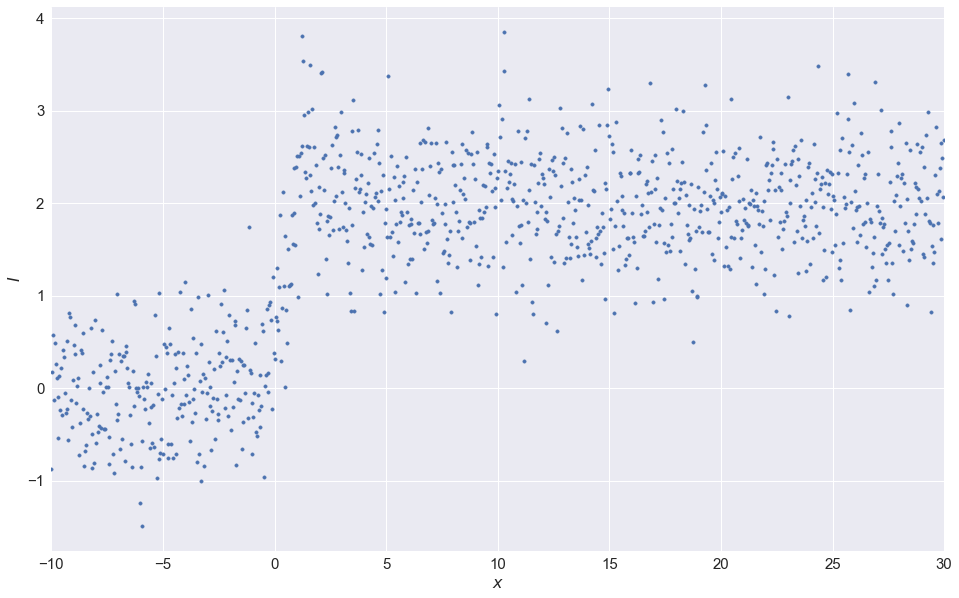

In [3]:
plt.figure(figsize=(16,10)) 

plt.scatter(x,y, marker='.') 
plt.xlim(-10,30)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$I$', fontsize=16)

### Definisikan model

In [4]:
from pymc3 import Model, Normal, HalfNormal

cc, ss = spc.fresnel(w / np.sqrt(np.pi/2))

# context manager syntax
with Model() as basic_model:
    # prior for unknown
    w = Normal('w', mu = 0., sd = 10.)
    dy = HalfNormal('error', sd = 1.)
    
    # expected values of outcome
    
    mu = 0.5 * (0.5 + cc + 0.5 + ss)**2
#     mu = spc.fresnel(w / np.sqrt(np.pi/2) )
    
    # likelihood of observations
    y_obs = Normal('y_obs', mu = mu, sd = dy, observed = y)

C:\Users\pj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Metode MAP untuk nilai awal

In [5]:
from pymc3 import find_MAP # menggunakan algoritma optimisasi BFGS (Broyden-Fletcher-Goldfarb-Shanno)

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

logp = -911.73, ||grad|| = 571: 100%|██████████████████████████████████████████████████| 8/8 [00:00<00:00, 2674.73it/s]


{'w': array(0.), 'error_log__': array(-0.64833236), 'error': array(0.52291709)}


### Sampling dengan NUTS

In [6]:
from pymc3 import NUTS, sample

with basic_model:
    start = find_MAP(method="L-BFGS-B") # MAP method untuk nilai awal
    
    # instantiate sampler
    step = NUTS(scaling=start)
    
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

logp = -911.73, ||grad|| = 571: 100%|██████████████████████████████████████████████████| 8/8 [00:00<00:00, 2001.22it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error_log__, w]


In [7]:
from pymc3 import summary
summary(trace, ['w','error'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w,0.076298,10.171679,0.099361,-18.966953,20.613785,9117.457709,0.999852
error,0.523473,0.011646,0.000124,0.500271,0.545454,8509.278237,0.999780


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019A5C7B5160>,
      dtype=object)

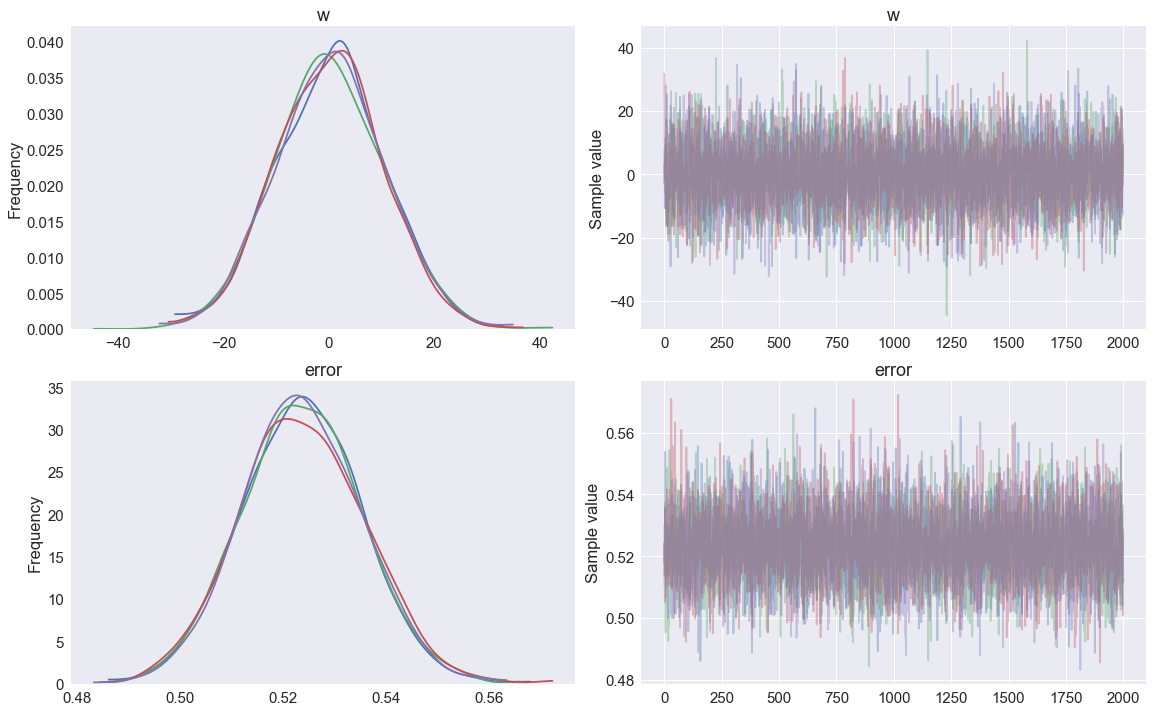

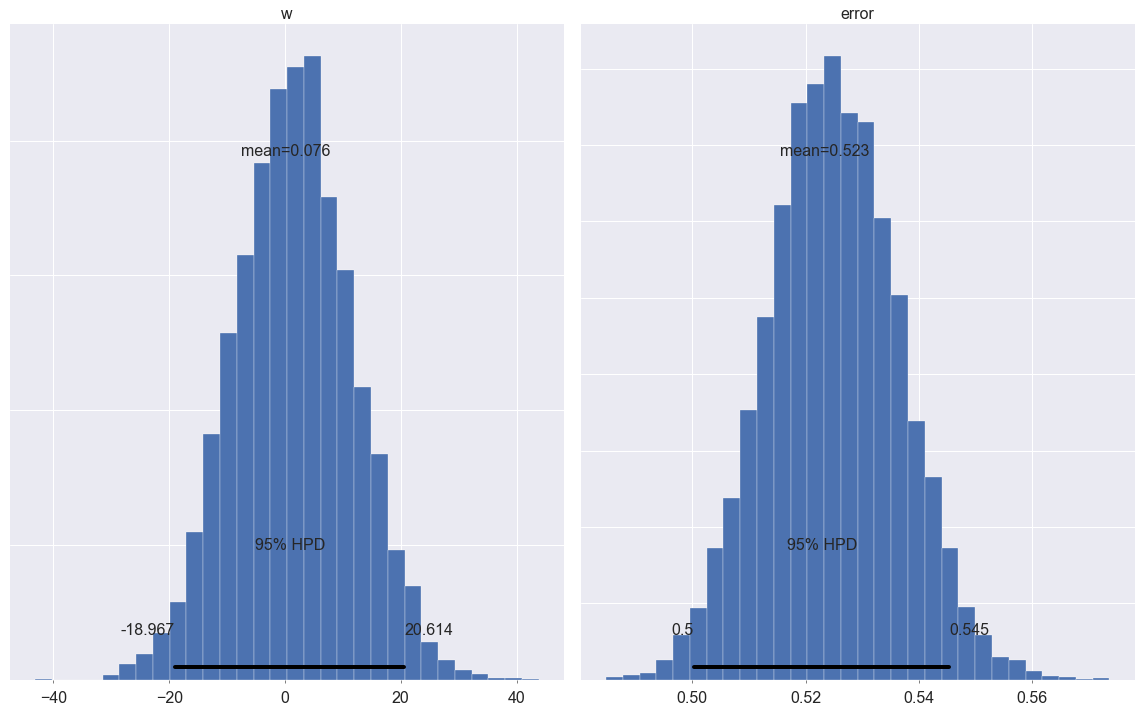

In [8]:
from pymc3 import traceplot
traceplot(trace, figsize = (16,10))

from pymc3 import plot_posterior
plot_posterior(trace, varnames=None, figsize = (16,10))

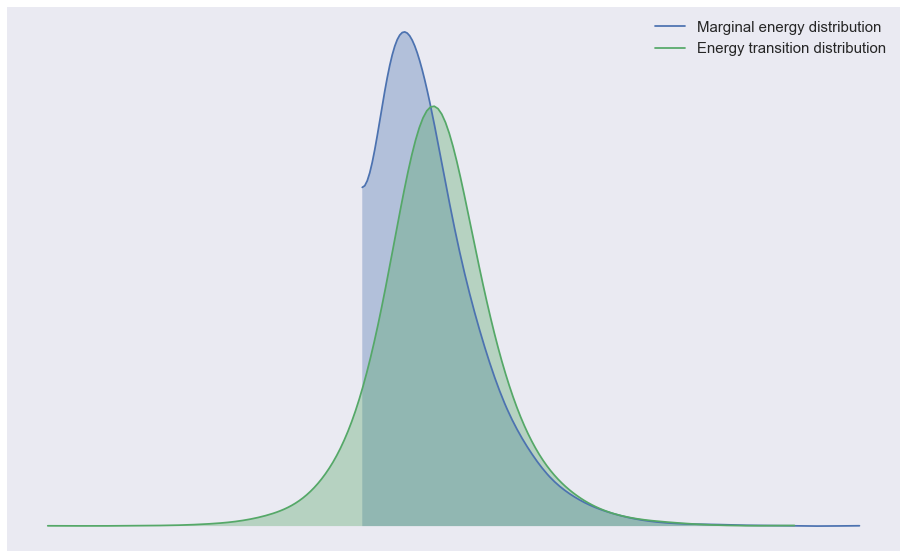

In [9]:
from pymc3 import energyplot
energyplot(trace, figsize = (16,10))

In [ ]:
size=(16,10)

plt.figure(figsize=size)

ax = plt.subplot()

xx = np.linspace(-100,100,num=8000)

n = len(xx)
m = len(trace['w'])
yy = np.zeros((n,m))

cc1, ss1 = spc.fresnel(np.mean(trace['w'][j]) / np.sqrt(np.pi/2))
yy = 0.5 * (0.5 + cc1 + 0.5 + ss1)**2
# yy = np.mean(trace['intercept']) + np.mean(trace['slope'])*xx
# total_yy = yy.sum(axis=1)
# plt.plot(x, y, 'o')
# yy1 = yy - np.mean(trace['error'])
# yy2 = yy + np.mean(trace['error'])

# plt.plot(x,y,'ok')
plt.scatter(x,y, marker='.', alpha=0.5)
# plt.plot(xx, total_yy, '-g')

# ax.plot(xx, yy, '-g', alpha=.5)
# ax.plot(xx, yy1, '--r', alpha=0.5)
# ax.plot(xx, yy2, '--r', alpha=0.5)
# plt.fill_between(xx, yy1, yy2, facecolor="gray", alpha=0.15)
len(trace['w'])

In [ ]:
trace['w'][100]